# Run parcel tracking with tracer

In [34]:
import numpy as np
from datetime import timedelta as delta, datetime
import xarray as xr
from parcels import FieldSet, Variable, ParticleSet, JITParticle, AdvectionRK4_3D, ErrorCode
import glob
import matplotlib.pyplot as plt

%matplotlib inline

#### Parameters

In [2]:
year = 2002

# Sub-domain dimensions:
jmin, jmax = 159, 799
imin, imax = 1139, 2179

#### General setup

Timestamps:

In [3]:
# Mesh mask
mesh_mask = '/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc'

# Lists of ANHA12 NEMO U,V,W files (on full ANHA12 domain)
folder_ANHA12      = '/data/brogalla/ANHA12/'
ANHA12_gridU_files = sorted(glob.glob(f'{folder_ANHA12}ANHA12-EXH006_y{year}m??d??_gridU.nc'))[0:20]
ANHA12_gridV_files = sorted(glob.glob(f'{folder_ANHA12}ANHA12-EXH006_y{year}m??d??_gridV.nc'))[0:20]
ANHA12_gridW_files = sorted(glob.glob(f'{folder_ANHA12}ANHA12-EXH006_5d_gridW_y{year}m??d??.nc'))[0:20]

# Lists of ANHA12 NEMO Pb tracer files (on sub-domain of full ANHA12 domain)
folder_Pb = f'/data/brogalla/run_storage/Pb-new-ini2-20220922/'
files_Pb  = sorted(glob.glob(f'{folder_Pb}ANHA12_EXH006_5d_{year}0101_{year}1231_ptrc_T_{year}*'))[0:20]

# Create timestamps from file dates: (because of time_origin issue in ANHA12 netcdf dynamics files)
time_stamps_files = []
for n, file in enumerate(ANHA12_gridU_files):
    dateU  = datetime.strptime(file[36:47],'y%Ym%md%d')
    dateV  = datetime.strptime(ANHA12_gridV_files[n][36:47],'y%Ym%md%d')
    dateW  = datetime.strptime(ANHA12_gridW_files[n][45:56],'y%Ym%md%d')
    datePb = datetime.strptime(files_Pb[n][99:107],'%Y%m%d')
    
    # double-check that the date is the same for all files
    if (dateU != dateV) | (dateU != dateW) | (dateU != datePb):
        print('Dates not equal!')
    else:   
        time_stamps_files.append(np.datetime64(f'{dateU.year:02}-{dateU.month:02}-{dateU.day:02}'))

# array of file timestamps
timestamps_files = np.expand_dims(np.array(time_stamps_files), axis=1)

Specify starting locations for particle sets:

In [26]:
release_time  = 0
release_lon   = [-130, -145, -70, -55] # east
release_lat   = [75, 74, 75, 65]       # north
release_depth = [1.0, 1.0, 1.0, 1.0]

#### Functions

In [4]:
def SampleW(particle, fieldset, time):
    particle.vovecrtz = fieldset.Pb[particle.time, particle.depth, particle.lat, particle.lon]

In [8]:
def DeleteParticle(particle, fieldset, time):
    print("Particle [%d] lost !! (%g %g %g %g)" % (particle.id, particle.lon, particle.lat, particle.depth, particle.time))
    particle.delete()

#### Run with vertical velocity as tracer (all variables on full domain):

In [7]:
filenames_W = {'U': {'lon': mesh_mask   , 'lat': mesh_mask  , 'depth': ANHA12_gridW_files[0], 'data': ANHA12_gridU_files},
               'V': {'lon': mesh_mask   , 'lat': mesh_mask  , 'depth': ANHA12_gridW_files[0], 'data': ANHA12_gridV_files},
               'W': {'lon': mesh_mask   , 'lat': mesh_mask  , 'depth': ANHA12_gridW_files[0], 'data': ANHA12_gridW_files},
               'Pb': {'lon': mesh_mask  , 'lat': mesh_mask  , 'depth': ANHA12_gridW_files[0], 'data': ANHA12_gridW_files}}

dimensions_W = {'U': {'lon': 'nav_lon', 'lat': 'nav_lat', 'depth': 'depthw'},
                'V': {'lon': 'nav_lon', 'lat': 'nav_lat', 'depth': 'depthw'},
                'W': {'lon': 'nav_lon', 'lat': 'nav_lat', 'depth': 'depthw'},
                'Pb': {'lon': 'nav_lon', 'lat': 'nav_lat', 'depth': 'depthw'}}

variables_W = {'U': 'vozocrtx',
               'V': 'vomecrty',
               'W': 'vovecrtz',
               'Pb': 'vovecrtz'}

# needed to provide time as timestamps in order to avoid time origin type issue
fieldset_W  = FieldSet.from_nemo(filenames_W, variables_W, dimensions_W, \
                                 timestamps=timestamps_files, \
                                 allow_time_extrapolation=False)

In [11]:
# define new particle class for Pb
class WParticle(JITParticle): 
    dissolvedPb = Variable('vovecrtz', initial=fieldset_W.Pb)  # Variable 'dissolpb' initialised by sampling the dissolved Pb field

In [12]:
pset1 = ParticleSet(fieldset=fieldset_W, pclass=WParticle, lon=release_lon, lat=release_lat, depth=release_depth, time=release_time)

output_file = pset1.ParticleFile(name="/ocean/brogalla/GEOTRACES/parcels/Pb-chapter/Pb-test1.zarr", outputdt=delta(hours=12))

pset1.execute(AdvectionRK4_3D + pset1.Kernel(SampleW), 
              runtime     = delta(hours=24*10), 
              dt          = delta(hours=2),
              output_file = output_file,
              recovery    = {ErrorCode.ErrorOutOfBounds: DeleteParticle})

INFO: Compiled ArrayWParticleAdvectionRK4_3DSampleW ==> /tmp/parcels-2672/libee60011c45815d4a971837c549925e54_0.so
INFO: Output files are stored in /ocean/brogalla/GEOTRACES/parcels/Pb-chapter/Pb-test1.zarr.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 864000.0/864000.0 [00:36<00:00, 23699.28it/s]


Works fine.

#### Run with Pb as tracer (Pb on sub-domain, U,V,W on full domain; no subset indices indicated)

In [10]:
filenames_Pb = {'U': {'lon': mesh_mask   , 'lat': mesh_mask  , 'depth': ANHA12_gridW_files[0], 'data': ANHA12_gridU_files},
                'V': {'lon': mesh_mask   , 'lat': mesh_mask  , 'depth': ANHA12_gridW_files[0], 'data': ANHA12_gridV_files},
                'W': {'lon': mesh_mask   , 'lat': mesh_mask  , 'depth': ANHA12_gridW_files[0], 'data': ANHA12_gridW_files},
                'Pb': {'lon': files_Pb[0], 'lat': files_Pb[0], 'depth': files_Pb[0], 'data': files_Pb}}

dimensions_Pb = {'U': {'lon': 'nav_lon', 'lat': 'nav_lat', 'depth': 'depthw'},
                 'V': {'lon': 'nav_lon', 'lat': 'nav_lat', 'depth': 'depthw'},
                 'W': {'lon': 'nav_lon', 'lat': 'nav_lat', 'depth': 'depthw'},
                 'Pb': {'lon': 'nav_lon', 'lat': 'nav_lat', 'depth': 'deptht'}}

variables_Pb = {'U': 'vozocrtx',
                'V': 'vomecrty',
                'W': 'vovecrtz',
                'Pb': 'dissolpb'}

# needed to provide time as timestamps in order to avoid time origin type issue
fieldset_Pb  = FieldSet.from_nemo(filenames_Pb, variables_Pb, dimensions_Pb, \
                                  timestamps=timestamps_files, \
                                  allow_time_extrapolation=False)

In [81]:
# define new particle class for Pb
class PbParticle(JITParticle): 
    dissolvedPb = Variable('dissolpb', initial=0)  # Variable 'dissolpb' initialised by sampling the dissolved Pb field

In [63]:
def SamplePb(particle, fieldset, time):
    particle.dissolpb = fieldset.Pb[particle.time, particle.depth, particle.lat, particle.lon]

In [72]:
x = np.arange(-140, -100, 1)
y = np.arange(65, 85, 1)
plon, plat = np.meshgrid(x, y) 
pset = ParticleSet(fieldset=fieldset_Pb, pclass=JITParticle, lon=plon, lat=plat, time=0) 

for i in range(len(pset)):
    d = np.hypot((pset.lon[i] - fieldset_Pb.U.grid.lon), (pset.lat[i] - fieldset_Pb.U.grid.lat))
    ind = np.unravel_index(np.argmin(d, axis=None), d.shape)
    pset.xi[i, :] = ind[1]
    pset.yi[i, :] = ind[0]
    
pset.execute(AdvectionRK4_3D, runtime=delta(hours=24*1), dt=0, recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})

INFO: Compiled ArrayJITParticleAdvectionRK4_3D ==> /tmp/parcels-2672/lib1e6ce0bac9f064bc633cd5a6acf6f8ef_0.so


Particle [33873] lost !! (-107 65 0.494025 0)
Particle [33913] lost !! (-107 66 0.494025 0)


In [101]:
x = np.arange(-140, -40, 1)
y = np.arange(65, 85, 0.5)
plon, plat = np.meshgrid(x, y) 
pset       = ParticleSet(fieldset=fieldset_Pb, pclass=PbParticle, lon=plon, lat=plat, time=0) 

## PbParticle works if I initialise the particle class with initial=0 instead of initial=fieldset_Pb.Pb

for i in range(len(pset)):
    d = np.hypot((pset.lon[i] - fieldset_Pb.U.grid.lon), (pset.lat[i] - fieldset_Pb.U.grid.lat))
    ind = np.unravel_index(np.argmin(d, axis=None), d.shape)
    pset.xi[i, :] = ind[1]
    pset.yi[i, :] = ind[0]
    
output_file = pset.ParticleFile(name="/ocean/brogalla/GEOTRACES/parcels/Pb-chapter/Pb-test2.zarr", outputdt=delta(hours=12))

pset.execute(AdvectionRK4_3D + pset.Kernel(SamplePb),
              runtime     = delta(hours=24*1), 
              dt          = delta(hours=2),
              output_file = output_file,
              recovery    = {ErrorCode.ErrorOutOfBounds: DeleteParticle});

INFO: Compiled ArrayPbParticleAdvectionRK4_3DSamplePb ==> /tmp/parcels-2672/libb8f09744747cdffac643b0336e663206_0.so


  Relative particle position:  (xsi, eta) 7.8887830603421867e+02 -3.1516483338404996e+01
Correct cell not found for (-49.045452, 83.998115) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 1665 829
            new particle indices: (yi, xi) 404 119
            Mesh 2d shape:  1040 640
            Relative particle position:  (xsi, eta) 8.0422500765086227e+02 -3.2913557246643997e+01
Correct cell not found for (-48.044182, 83.998104) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 1663 831
            new particle indices: (yi, xi) 404 117
            Mesh 2d shape:  1040 640
            Relative particle position:  (xsi, eta) 8.1489765891366324e+02 -3.6815749885147873e+01
Correct cell not found for (-47.043402, 83.998149) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 1662 834
            new particle indices: (yi, xi) 404 116
            Mesh 2d shape:  1040 640
            Relative particle position:  (xsi, eta) 8.14864648977

INFO: Output files are stored in /ocean/brogalla/GEOTRACES/parcels/Pb-chapter/Pb-test2.zarr.
  0%|                                                                                                                                                               | 0/86400.0 [00:00<?, ?it/s]

Particle [40791] lost !! (-64.6406 64.9983 0.495371 72000)
Particle [41562] lost !! (-79.0258 66.9781 0.4947 43200)
Particle [41604] lost !! (-57.9785 66.9359 0.494752 72000)
Particle [41605] lost !! (-57.4749 66.9543 0.495288 50400)
Particle [41762] lost !! (-79.0345 67.4477 0.494622 79200)
Particle [41794] lost !! (-62.8791 67.4373 0.498539 79200)
Particle [41796] lost !! (-61.9245 67.4723 0.494341 43200)
Particle [41798] lost !! (-60.9416 67.4726 0.494709 43200)
Particle [41919] lost !! (-100.489 68.0004 0.494817 57600)
Particle [41956] lost !! (-82.0152 67.9732 0.497177 50400)
Particle [41992] lost !! (-63.9088 67.9047 0.505047 50400)
Particle [41993] lost !! (-63.4247 67.9593 0.494289 43200)
Particle [42004] lost !! (-58.0052 67.975 0.494137 50400)
Particle [42012] lost !! (-54.0262 68.0029 0.494139 72000)
Particle [42096] lost !! (-111.948 68.4992 0.498487 64800)
Particle [42148] lost !! (-86.0014 68.5309 0.494575 50400)
Particle [42163] lost !! (-78.6177 68.4562 0.49403 72000)
P

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86400.0/86400.0 [00:04<00:00, 20071.64it/s]


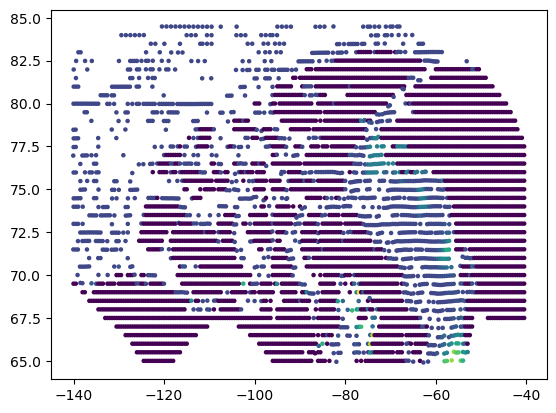

In [102]:
plt.scatter(pset.lon,pset.lat, c=pset.dissolpb, s=5)